In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-02 22:07:12.156354: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-02 22:07:12.188129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 22:07:12.188632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-02 22:07:12.188807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-02 22:07:12.190187: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-02 22:07:12.191421: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
batch_size = 15
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",           # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [7]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='binary'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
15


2023-06-02 22:07:12.926655: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-02 22:07:12.930229: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-02 22:07:12.930590: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff5a0001040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-02 22:07:12.930604: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-02 22:07:12.998213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 22:07:12.998615: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59c2bc0 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [10]:
print(images_in_batch.shape)

(15, 224, 224, 3)


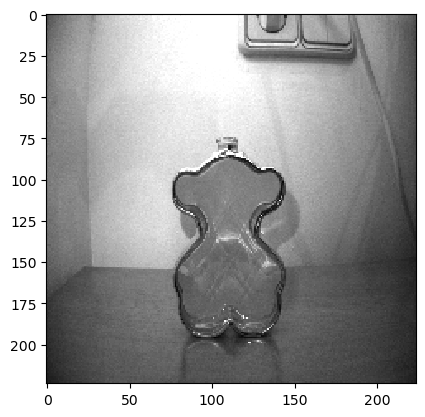

In [11]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [12]:

# batch_size = 16
latent_dim = 32  # Number of latent dimension parameters

input_img = Input(shape=(SIZE, SIZE, 3))
x = Conv2D(128, (3, 3), activation='relu', padding='same') (input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 7, 7, 1)
(None, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None

In [13]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(14*14*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)
x = Reshape((14,14,4),input_shape=(784,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 784)               25872     
_________________________________________________________________
original_decoder (Dense)     (None, 784)               615440    
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 3)         84  

In [14]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mse')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0   

These are the weights of a specific layer of the encoder model, before training are:

In [15]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 0.01032162, -0.05029436, -0.03020895, ..., -0.01535565,
          -0.000856  ,  0.03382622],
         [ 0.00624896, -0.05251391, -0.02855037, ..., -0.02142391,
          -0.00802774,  0.02268483],
         [ 0.01142083, -0.00300302,  0.05406024, ...,  0.04998857,
           0.00167073, -0.05207699]],

        [[ 0.01877455, -0.00627241, -0.02132173, ...,  0.03975246,
          -0.01959515, -0.00439045],
         [-0.06961619,  0.05283757, -0.00020645, ..., -0.07089369,
          -0.02962762, -0.05762259],
         [ 0.06434675,  0.03858597,  0.06156276, ...,  0.06699583,
          -0.03800206,  0.06005298]],

        [[-0.01811915,  0.04034404,  0.02022436, ..., -0.05119215,
           0.06356199,  0.04646232],
         [ 0.02703324, -0.06144471,  0.01212934, ...,  0.00098969,
           0.00520353, -0.03378547],
         [ 0.05496475

These are the weights of a specific layer of the decoder model,before training are:

In [16]:
# layer_number = 1
# print("quantity of layers in the model: ", len(decoder.layers))
# print("The weigths in the", decoder.layers[layer_number].name, "is: ", decoder.layers[layer_number].weights)

These are the weights of a specific layer of the autoencoder model,before training are:

In [17]:
# layer_number = 1
# print("quantity of layers in the model: ", len(ae.layers))
# print("The weigths in the", ae.layers[layer_number].name, "is: ", ae.layers[layer_number].weights)

In [18]:
# from tensorflow.keras.callbacks import EarlyStopping
# # run the model
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=5, mode='auto')
# history = ae.fit(train_generator, epochs=2000, validation_data=validation_generator, callbacks=[early_stopping],verbose=1)

In [19]:

# # Get the training and validation loss values from the history object
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']

# # Plot the training and validation loss
# epochs = range(1, len(train_loss) + 1)
# plt.plot(epochs, train_loss, 'b-', label='Training Loss')
# plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


In [20]:
model_version = 'NewAutoencoderModel11'
print(model_version)

NewAutoencoderModel11


In [21]:
# ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

In [22]:
print(type(ae))

<class 'tensorflow.python.keras.engine.training.Model'>


Loading the model that was previously saved


In [23]:
model = keras.models.load_model('../models/NewAutoencoderModel11')
print(type(model))

<class 'tensorflow.python.keras.engine.training.Model'>


## See the weights after the model loading

These are the weights of a specific layer of the encoder model, AFTER training:

In [24]:
layer_number = 1
print("quantity of layers in the model: ", len(encoder.layers))
print("The weigths in the", encoder.layers[layer_number].name, "is: ", encoder.layers[layer_number].weights)

quantity of layers in the model:  15
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 0.01032162, -0.05029436, -0.03020895, ..., -0.01535565,
          -0.000856  ,  0.03382622],
         [ 0.00624896, -0.05251391, -0.02855037, ..., -0.02142391,
          -0.00802774,  0.02268483],
         [ 0.01142083, -0.00300302,  0.05406024, ...,  0.04998857,
           0.00167073, -0.05207699]],

        [[ 0.01877455, -0.00627241, -0.02132173, ...,  0.03975246,
          -0.01959515, -0.00439045],
         [-0.06961619,  0.05283757, -0.00020645, ..., -0.07089369,
          -0.02962762, -0.05762259],
         [ 0.06434675,  0.03858597,  0.06156276, ...,  0.06699583,
          -0.03800206,  0.06005298]],

        [[-0.01811915,  0.04034404,  0.02022436, ..., -0.05119215,
           0.06356199,  0.04646232],
         [ 0.02703324, -0.06144471,  0.01212934, ...,  0.00098969,
           0.00520353, -0.03378547],
         [ 0.05496475

These are the weights of a specific layer of the Autoencoder model, AFTER training:

In [25]:
layer_number = 1
print("quantity of layers in the model: ", len(model.layers))
print("The weigths in the", model.layers[layer_number].name, "is: ", model.layers[layer_number].weights)

quantity of layers in the model:  16
The weigths in the conv2d is:  [<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
array([[[[ 4.86705750e-02, -1.00794481e-02, -3.71609479e-02, ...,
           6.63664378e-03, -2.62752473e-02,  1.52181983e-02],
         [-2.57558953e-02,  4.69970703e-03, -3.38478126e-02, ...,
           4.60498743e-02, -5.99247329e-02,  9.08346288e-03],
         [-7.20606446e-02,  6.18688315e-02, -1.10166566e-02, ...,
          -4.45386283e-02, -1.12277195e-02, -3.21656279e-02]],

        [[-5.33120334e-02,  6.21773899e-02, -5.64917848e-02, ...,
           5.60613209e-03, -5.13667762e-02,  2.08525383e-03],
         [-1.41293500e-02,  9.29411799e-02, -6.25193119e-02, ...,
           4.24761847e-02, -5.82221262e-02,  6.42304420e-02],
         [ 6.25705421e-02,  8.72997195e-02,  2.59574372e-02, ...,
          -1.64631139e-02, -5.91281019e-02, -1.44937662e-02]],

        [[-5.44126444e-02,  9.03613493e-02, -4.46478487e-04, ...,
           4.094345

Indeed the weights of the "Autoencoder" model have been updated but the ones from the "Encoder" have not. This is expected, since the model that was trained was actually the "Autoencoder" mdoel.

## Perform an Autoencoder reconstruction in one image

Get all batches generated by the datagen and pick a batch for prediction

In [26]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  12


In [27]:
print(len(data_batch))

12


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [28]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(15, 224, 224, 3)


2023-06-02 22:07:16.925130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-02 22:07:17.120319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


(15, 224, 224, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [29]:
single_img = data_batch[0][0]

In [30]:
print(single_img.shape)

(224, 224, 3)


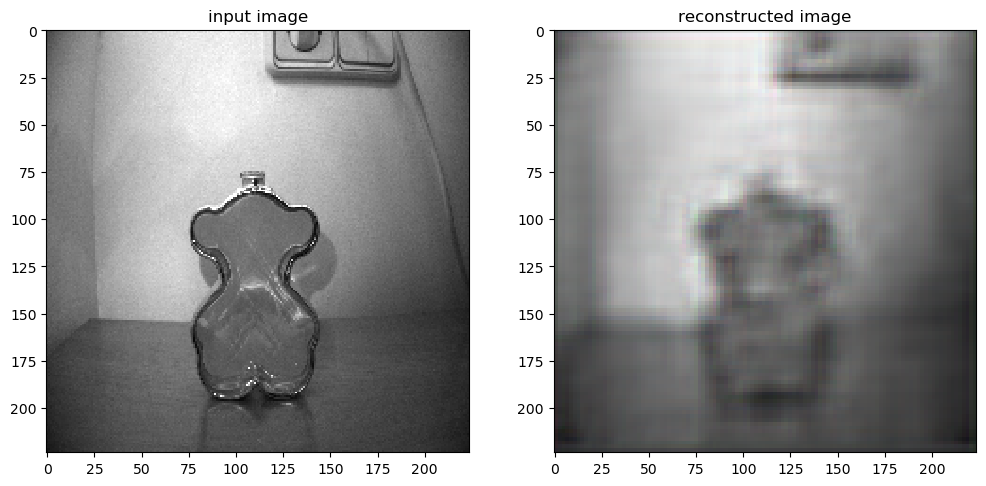

In [31]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

# Quantifying the reconstruction error using "evaluate_generator()" function

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [32]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Recon. error for the validation (normal) data is:  0.003671717131510377


This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [33]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

Recon. error for the anomaly data is:  0.003242534352466464


See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [34]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

Recon. error for the training (non-anomaly) data is:  0.0031200312077999115


See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [35]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [36]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

1/1 [==============================] - 0s 586us/step - loss: 0.0034
The list of rec. error contains  12 batches of rec. errors


In [37]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

179


In [38]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.003836096341165001
The standard deviation of the errors list is:  0.0006134692181701534
The min value of the errors list is:  0.002658457262441516
The max value of the errors list is:  0.006352019030600786


Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [39]:
anomaly_batch = anomaly_generator.next()

In [40]:
total_rec_error_anomalies = []
for i in range(len(anomaly_generator)):        #I think this should be the correct while clause
    data = anomaly_generator.next()
    total_rec_error_anomalies.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_anomalies), "batches of rec. errors")

1/1 [==============================] - 0s 1ms/step - loss: 0.0056
The list of rec. error for anomalies contains  1 batches of rec. errors


In [41]:
total_rec_error_anomalies = [item for sublist in total_rec_error_anomalies for item in sublist]
print(len(total_rec_error_anomalies))

6


In [42]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  0.004095934991103907
The standard deviation of the errors list is:  0.0008754911464010074
The min value of the errors list is:  0.0028889039531350136
The max value of the errors list is:  0.005580530036240816


Compute the average and std dev. of recon. error for the validation (non-anomalies) samples. 


In [43]:
total_rec_error_validation = []
for i in range(len(validation_generator)):        #I think this should be the correct while clause
    data = validation_generator.next()
    total_rec_error_validation.append(calc_recon_error(data[0]))
    
print("The list of rec. error for anomalies contains ", len(total_rec_error_validation), "batches of rec. errors")

1/1 [==============================] - 0s 600us/step - loss: 0.0037
The list of rec. error for anomalies contains  2 batches of rec. errors


In [44]:
total_rec_error_validation = [item for sublist in total_rec_error_validation for item in sublist]
print(len(total_rec_error_validation))

30


In [45]:
val_average_recon_error = np.mean(np.array(total_rec_error_validation))  
val_stdev_recon_error = np.std(np.array(total_rec_error_validation)) 
min_prob = np.min(total_rec_error_validation)
max_prob = np.max(total_rec_error_validation)
print("THIS IS FOR THE VALIDATION IMAGES\n")
print("The average of the errors list is: ", val_average_recon_error)
print("The standard deviation of the errors list is: ", val_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE VALIDATION IMAGES

The average of the errors list is:  0.0035499623976647855
The standard deviation of the errors list is:  0.0002890400612593702
The min value of the errors list is:  0.0029769677203148603
The max value of the errors list is:  0.004379247315227985


Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

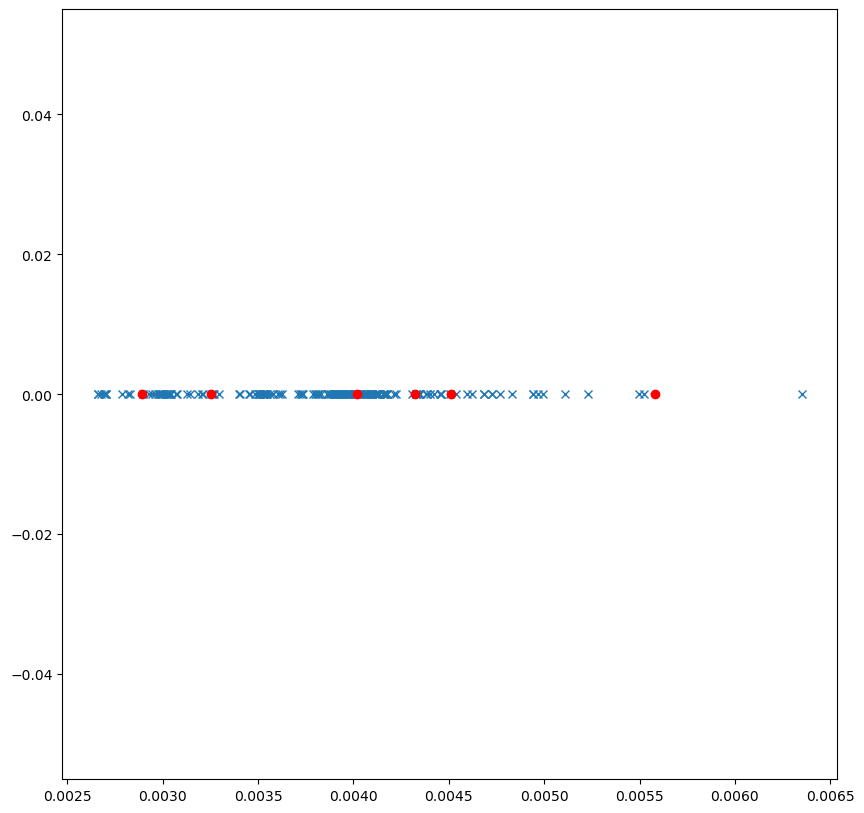

In [46]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

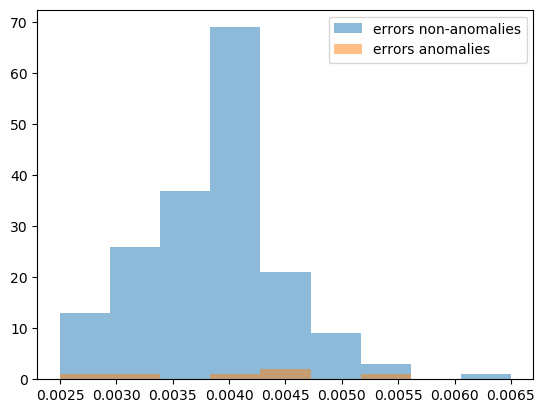

In [47]:
import random
import numpy
from matplotlib import pyplot

bins = numpy.linspace(0.0025, 0.0065, 10)

pyplot.hist(total_rec_error_list, bins, alpha=0.5, label='errors non-anomalies')
pyplot.hist(total_rec_error_anomalies, bins, alpha=0.5, label='errors anomalies')
pyplot.legend(loc='upper right')
pyplot.show()

## Checking the latent space

Let's update the weights of the encoder model.

In [48]:
# Copy the layer weights from the base model to the target model
for i, target_layer in enumerate(encoder.layers):
    base_layer = model.layers[i]
    target_layer.set_weights(base_layer.get_weights())

# Verify if the weights are successfully copied
for base_layer, target_layer in zip(model.layers[:len(encoder.layers)], encoder.layers):
    base_weights = base_layer.get_weights()
    target_weights = target_layer.get_weights()
    for base_weight, target_weight in zip(base_weights, target_weights):
        if (base_weight == target_weight).all():
            print("Layer weights are successfully copied.")
        else:
            print("Error: Layer weights are not copied correctly.")


Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.
Layer weights are successfully copied.


In [49]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [50]:
print(encoded_images.shape)

(179, 32)


See that it is 179 length because it corresponds to all the images that belong to the training dataset. The second length corresponds to the output shape of the model as specified in its structure at the beginning.

In [51]:
type(encoded_images)

numpy.ndarray

In [52]:
encoder_output_shape = encoder.output_shape 
print(encoder_output_shape)

(None, 32)


Now, let's fit KDE to the image latent data

In [53]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

The above function fits a kernel density estimation to the data that is provided, that is, the "encoded_images" variable. It does so using a Guassian kernel of bandwidth 0.2.

The badnwidth parameter affects on how the selected kernel will fit each sample of the given data. For example for the case in which the kernel is a Gaussian distribution, the bandwidth parameter would affect in how thin or wide is the Gaussian distribution.

At this point in the variable "kde" we have some numbers that are the result of fitting Gaussian functions to the given data points in the variable "encoded_images". We will use the "kde" variable later for scoring with it, some given data points; the scoring will be given depending on how similar are the given data points to the ones that it had estimated.

Here below, it is shown the kde values corresponding to each encoded sample. THese are supposed to be very close to each other in value.

In [54]:
density_vals = kde.score_samples(encoded_images)
print(density_vals)

[18.79521874 18.73319492 18.77413114 20.15819226 20.60129103 20.12946468
 20.36818593 20.22912704 20.2867228  20.4613345  20.6247393  20.57983578
 18.92091636 18.99807891 19.31290507 20.15127232 20.5429996  20.08609155
 20.37091698 18.76221116 18.58805352 18.57803434 18.77943739 18.90473122
 20.07881316 19.38642559 18.82912803 18.50615089 18.9294018  19.02984692
 19.66655578 20.59557825 18.99135432 19.00751729 19.00839159 18.66002556
 18.80559673 18.85352051 18.85842887 19.02126072 19.59105751 20.62903823
 19.83609353 19.71058934 19.4311895  18.70166347 18.746497   18.76265826
 18.66238448 18.58928568 19.07173888 20.06881573 20.65011698 20.65307038
 20.21428147 19.42825019 19.98820476 19.86401305 19.85308079 19.91373835
 19.70031568 20.23164686 20.09964046 20.62179272 20.64933207 20.66017524
 20.61190101 20.62722064 20.64035981 20.31172897 20.59342492 20.55560264
 20.29960541 19.80187948 19.34510461 19.8274992  19.75298227 19.65984205
 19.61938695 19.88922523 19.70031568 20.23164686 20

From here, the mean and standard deviation of these values are computed

In [55]:
average_density = np.mean(density_vals)
stdev_density = np.std(density_vals)
print("The avg of the density values is: ", average_density)
print("The stdev_density of the density values is: ", stdev_density)

The avg of the density values is:  19.886525782463476
The stdev_density of the density values is:  0.5974230189092039


based on the above data create a function that outputs a probability of a KDE value to be considered an anomaly or non-anomaly image

In [56]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [57]:
def map_kde2prob_list(input_list):
    threshold = average_density          # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density            # The std deviation of the kde corresponding to the non-anomaly images
    prob_score_list = []
    prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
    for i in range (len(input_list)):
        aux_score = input_list[i] - threshold
        if aux_score>=0:
            additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
            prob_score_tot = prob_score+additional
        else:
            additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
            prob_score_tot = prob_score-additional
        if prob_score_tot > 100:
            prob_score_tot = 100
        if prob_score_tot < 0:
            prob_score_tot = 0
        prob_score_list.append(prob_score_tot)
    return prob_score_list

In [58]:
def map_kde2prob(value):
    threshold = average_density         # The mean of the kde corresponding to the non-anomaly images
    std_dev = stdev_density          # The std deviation of the kde corresponding to the non-anomaly images
    prob_score = 0              # This was changed for making threshold+std_dev be mapped to be 50% chance. Before it was directly mapped threshold value to 50% chance
    aux_score = value - threshold
        
    if aux_score>=0:
        additional = ranges_mapper(aux_score, 0, std_dev, 0, 50)
        prob_score_tot = prob_score+additional
    else:
        additional = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        prob_score_tot = prob_score-additional
    if prob_score_tot > 100:
        prob_score_tot = 100
    if prob_score_tot < 0:
        prob_score_tot = 0    
    return prob_score_tot

In [59]:
def computePred(kde_value):
    pred = 0
    prob_anomaly = map_kde2prob(kde_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred

In [60]:
print(map_kde2prob_list([average_density + stdev_density-0.001]))

[49.91630720876583]


In [61]:
#Get encoded output of input images = Latent space
encoded_images_test_set = encoder.predict_generator(test_set_generator)

In [62]:
print(encoded_images_test_set.shape)

(30, 32)


In [63]:
density_vals_test = kde.score_samples(encoded_images_test_set)
print(density_vals_test)

[19.50978819 19.97815951 20.14968218 20.13248129 20.19910614 20.19940995
 20.17432546 20.15296595 19.99479064 20.13695923 19.01231256 19.04211674
 18.82709592 19.27730402 19.92237104 19.25190454 20.07755351 20.19143159
 19.76740296 19.01379577 19.10556922 18.9556064  18.9068179  18.97491276
 19.33280292 20.03605329 19.8805309  20.09197566 20.10961956 20.07486268]


In [64]:
average_density + stdev_density

20.48394880137268

In [65]:
prob_test = map_kde2prob_list(density_vals_test)
print(prob_test)

[0, 7.6690826002508, 22.024293636931905, 20.58470275740064, 26.160722551747472, 26.18614911014565, 24.086758399710213, 22.299121065352097, 9.06098830690806, 20.9594742167656, 0, 0, 0, 0, 2.9999897561612707, 0, 15.987643684041336, 25.518418009347204, 0, 0, 0, 0, 0, 0, 0, 12.514374575873388, 0, 17.19467372922697, 18.671340792197274, 15.76244052118614]


See the final predictions based on the KDE average values that was computed before.

In [66]:
ground_truth = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    _, labels = test_set_generator.next()
    ground_truth.append(labels)
    
print("The list of rec. error for anomalies contains ", len(ground_truth), "batches of rec. errors")

The list of rec. error for anomalies contains  2 batches of rec. errors


In [67]:
ground_truth = [item for sublist in ground_truth for item in sublist]
ground_truth = [int(x) for x in ground_truth]


In [68]:
pred_list =[]
for i in range(len(prob_test)):
    
    if(prob_test[i]>50):
        pred = 1
    else:
        pred = 0
    pred_list.append(pred)
print(ground_truth)
print(pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## See the data separation in the latent space

In [69]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [70]:
vis_imgs = []
for i in range(len(test_set_generator)):        #I think this should be the correct while clause
    data = test_set_generator.next()
    images_in_batch = data[0]
    latent_vec = encoder(images_in_batch)
    for i in range(batch_size):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(images_in_batch[i]))


In [71]:
print(latent_vec.shape)
print(len(vis_imgs))

(15, 32)
30


In [72]:
from PIL import Image
from sklearn.manifold import TSNE

def visualize_space(X,images,outfile):

    tsne = TSNE(n_components=2, perplexity=2, learning_rate='auto', init='random').fit_transform(X)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 40000
    height = 30000


    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        img = np.array(img)
        tile = Image.fromarray(np.uint8(img*255))
        full_image.paste(tile, (int((width-60)*x), int((height-60)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (66,50))
    plt.imshow(full_image)
    plt.axis("off")
    full_image.save(outfile)

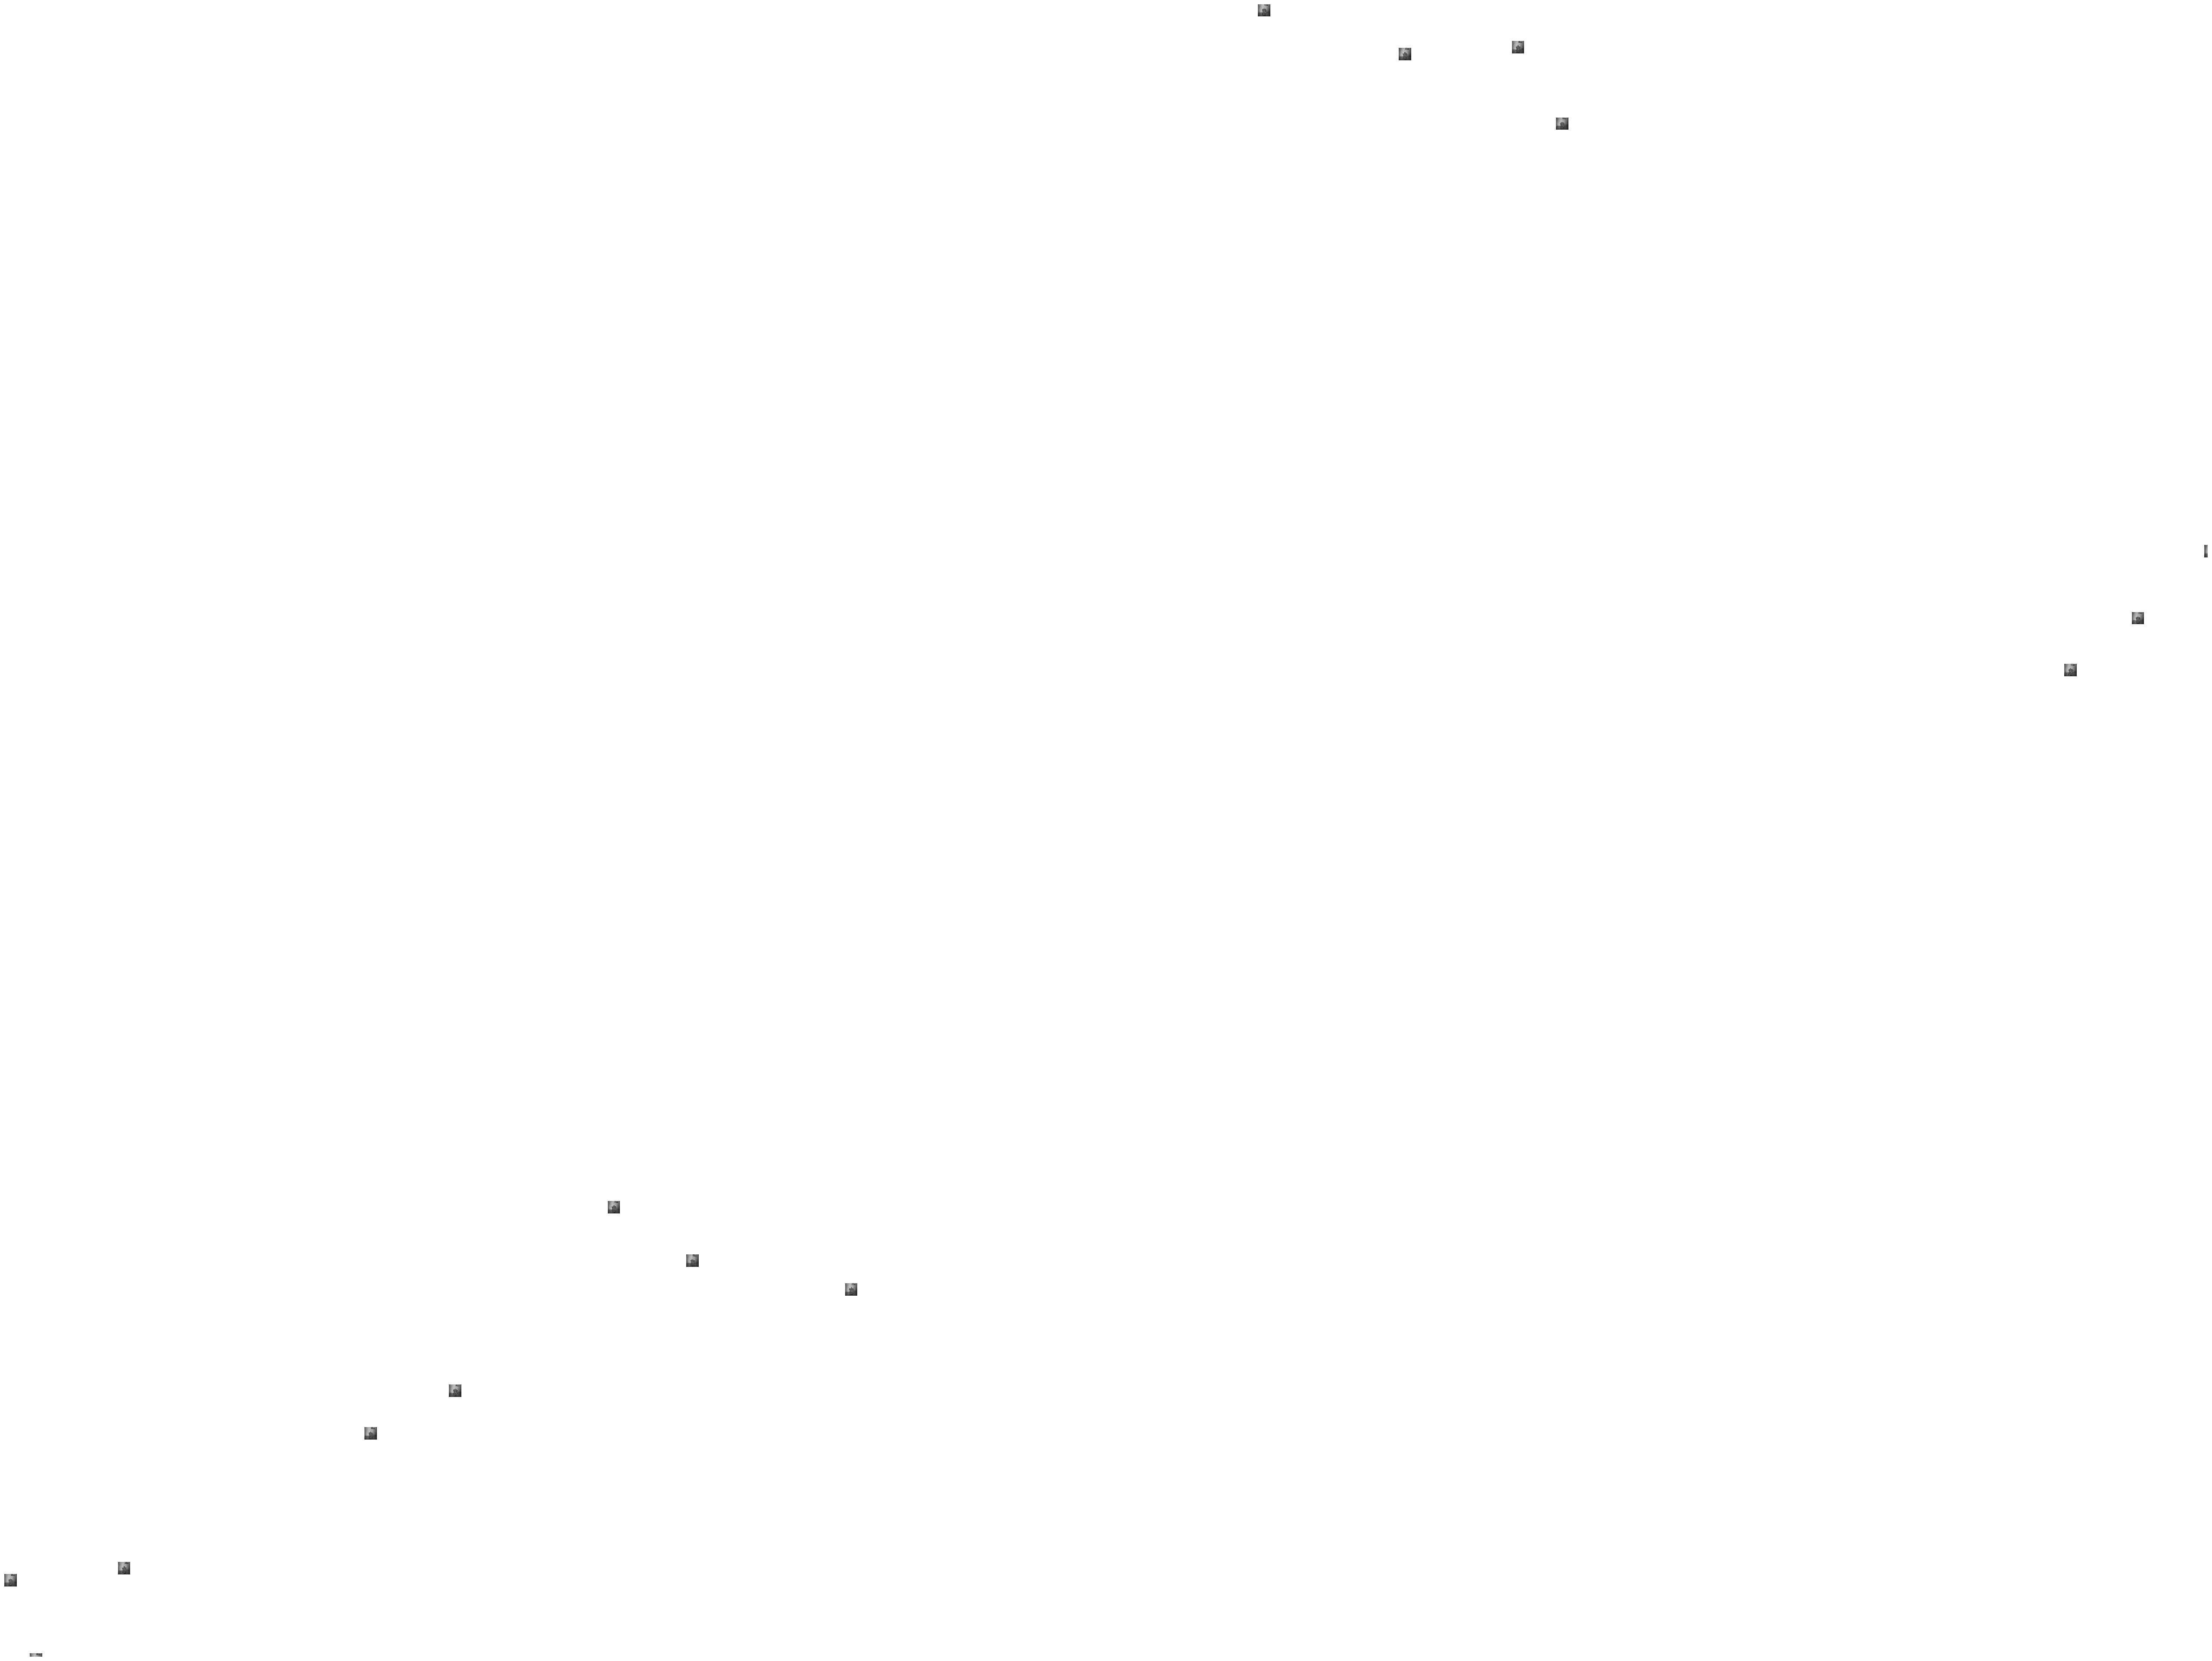

In [73]:
X= np.array(latent_vec)

visualize_space(X,vis_imgs,"tSNE-Latent-bottles2.png")